In [ ]:
%%writefile your_lora_module.py
from dataclasses import dataclass

@dataclass
class LORAConfig:
    r: int
    alpha: float


Overwriting your_lora_module.py


In [ ]:
import os
import random
import zipfile
import numpy as np
import torch
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import cosine
from sklearn.metrics import roc_curve, auc
from transformers import WavLMForXVector, AutoFeatureExtractor
from your_lora_module import LORAConfig

In [ ]:
vox1_dir = "/kaggle/input/vox-1-test-wav/wav"
vox2_dir = "/kaggle/input/vow-2-test/aac"
model_name = "microsoft/wavlm-base-plus"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print("Loading pre-trained model and feature extractor...")
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = WavLMForXVector.from_pretrained(model_name, ignore_mismatched_sizes=True).to(device)
model.eval()
print("Pre-trained WavLM model loaded successfully!")

Loading pre-trained model and feature extractor...


Some weights of WavLMForXVector were not initialized from the model checkpoint at microsoft/wavlm-base-plus and are newly initialized: ['classifier.bias', 'classifier.weight', 'feature_extractor.bias', 'feature_extractor.weight', 'objective.weight', 'projector.bias', 'projector.weight', 'tdnn.0.kernel.bias', 'tdnn.0.kernel.weight', 'tdnn.1.kernel.bias', 'tdnn.1.kernel.weight', 'tdnn.2.kernel.bias', 'tdnn.2.kernel.weight', 'tdnn.3.kernel.bias', 'tdnn.3.kernel.weight', 'tdnn.4.kernel.bias', 'tdnn.4.kernel.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pre-trained WavLM model loaded successfully!


In [ ]:
def extract_speaker_embedding(audio_path, model_obj=model):
    waveform, sample_rate = torchaudio.load(audio_path)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    resampler = T.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resampler(waveform)
    waveform = (waveform - waveform.mean()) / waveform.std()
    inputs = feature_extractor(waveform.squeeze(0), sampling_rate=16000, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        embeddings = model_obj(**inputs).embeddings
    return embeddings.cpu().numpy().flatten()


In [ ]:
print("Building trial pairs for evaluation...")
speaker_dict = {}
speaker_ids = sorted(os.listdir(vox1_dir))
for speaker in speaker_ids:
    speaker_path = os.path.join(vox1_dir, speaker)
    if os.path.isdir(speaker_path):
        audio_files = []
        for root, dirs, files in os.walk(speaker_path):
            for file in files:
                if file.endswith(".wav"):
                    audio_files.append(os.path.join(root, file))
        if audio_files:
            speaker_dict[speaker] = audio_files
print(f"Found {len(speaker_dict)} speakers with audio files.")

Building trial pairs for evaluation...
Found 40 speakers with audio files.


In [ ]:
trial_pairs = []
for speaker, files in speaker_dict.items():
    if len(files) >= 2:
        file1, file2 = random.sample(files, 2)
        trial_pairs.append(("1", file1, file2))
speaker_keys = list(speaker_dict.keys())
num_negatives = len(trial_pairs)
while len(trial_pairs) < (2 * num_negatives):
    spk1, spk2 = random.sample(speaker_keys, 2)
    file1 = random.choice(speaker_dict[spk1])
    file2 = random.choice(speaker_dict[spk2])
    trial_pairs.append(("0", file1, file2))

In [ ]:
scores = []
labels = []
for label, path1, path2 in trial_pairs:
    emb1 = extract_speaker_embedding(path1)
    emb2 = extract_speaker_embedding(path2)
    sim = 1 - cosine(emb1, emb2)
    scores.append(sim)
    labels.append(1 if label == "1" else 0)

fpr, tpr, thresholds = roc_curve(labels, scores)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
eer = fpr[np.nanargmin(np.abs(fnr - fpr))] * 100  # in %
far_threshold_idx = np.where(fpr <= 0.01)[0][-1]
tar_at_1_fpr = tpr[far_threshold_idx] * 100
accuracy = np.mean([(score > eer_threshold) == label for score, label in zip(scores, labels)]) * 100


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
print(f"Pre-trained Model Evaluation:")
print(f"EER (Equal Error Rate): {eer:.2f}%")
print(f"TAR@1%FAR: {tar_at_1_fpr:.2f}%")
print(f"Speaker Identification Accuracy: {accuracy:.2f}%")

Pre-trained Model Evaluation:
EER (Equal Error Rate): 42.50%
TAR@1%FAR: 2.50%
Speaker Identification Accuracy: 58.75%


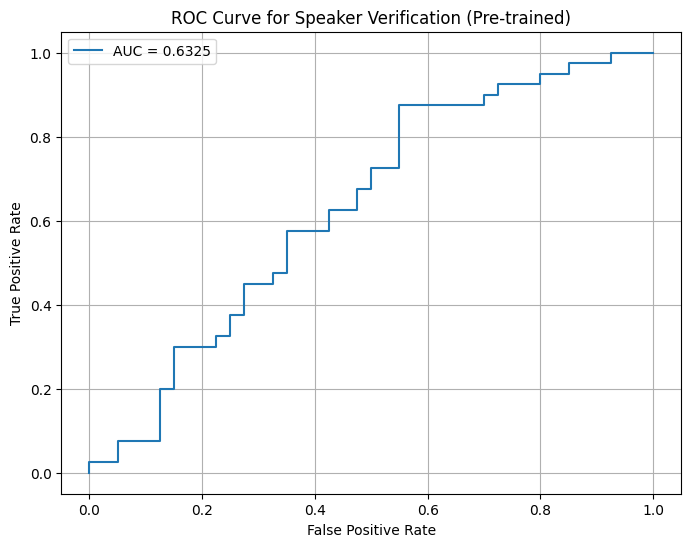

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Speaker Verification (Pre-trained)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
all_ids_vox2 = sorted(os.listdir(vox2_dir))
train_ids = all_ids_vox2[:100]
test_ids = all_ids_vox2[100:]
print(f"VoxCeleb2: Using {len(train_ids)} speakers for training and {len(test_ids)} for testing.")

VoxCeleb2: Using 100 speakers for training and 18 for testing.


In [ ]:
class VoxCeleb2Dataset(Dataset):
    def __init__(self, root_dir, speaker_list):
        self.samples = []
        self.speaker_list = speaker_list
        for speaker in speaker_list:
            speaker_path = os.path.join(root_dir, speaker)
            if os.path.isdir(speaker_path):
                for root, _, files in os.walk(speaker_path):
                    for file in files:
                        if file.endswith(".m4a") or file.endswith(".wav"):
                            self.samples.append((speaker, os.path.join(root, file)))
        self.speaker2label = {spk: idx for idx, spk in enumerate(sorted(speaker_list))}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        speaker, audio_path = self.samples[idx]
        label = self.speaker2label[speaker]
        waveform, sr = torchaudio.load(audio_path)
        max_samples = 160000
        if waveform.shape[1] > max_samples:
            waveform = waveform[:, :max_samples]
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        resampler = T.Resample(orig_freq=sr, new_freq=16000)
        waveform = resampler(waveform)
        waveform = (waveform - waveform.mean()) / waveform.std()
        inputs = feature_extractor(waveform.squeeze(0), sampling_rate=16000, return_tensors="pt", padding=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, label

In [ ]:
def collate_fn(batch):
    input_list = [item[0]["input_values"] for item in batch]
    labels = torch.tensor([item[1] for item in batch])
    padded_inputs = torch.nn.utils.rnn.pad_sequence(input_list, batch_first=True)
    return {"input_values": padded_inputs, "sampling_rate": 16000}, labels

In [ ]:
train_dataset = VoxCeleb2Dataset(root_dir=vox2_dir, speaker_list=train_ids)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
print(f"VoxCeleb2 training dataset has {len(train_dataset)} samples.")

VoxCeleb2 training dataset has 29831 samples.


In [ ]:
class LoRALinear(torch.nn.Module):
    def __init__(self, linear_module, lora_config: LORAConfig):
        super().__init__()
        self.linear = linear_module
        self.r = lora_config.r
        self.alpha = lora_config.alpha
        self.A = torch.nn.Parameter(torch.empty(self.r, linear_module.in_features, device=device, dtype=torch.float16))
        self.B = torch.nn.Parameter(torch.zeros(linear_module.out_features, self.r, device=device, dtype=torch.float16))
        torch.nn.init.normal_(self.A, mean=0, std=0.01)

    def forward(self, x):
        x = x.to(torch.float32)
        delta_w = self.alpha * (self.B @ self.A)
        delta_w = delta_w.to(torch.float32)
        return self.linear(x) + torch.nn.functional.linear(x, delta_w.t())


In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model_ft = WavLMForXVector.from_pretrained(
    model_name,
    ignore_mismatched_sizes=True
)
model_ft = model_ft.to(device)


Some weights of WavLMForXVector were not initialized from the model checkpoint at microsoft/wavlm-base-plus and are newly initialized: ['classifier.bias', 'classifier.weight', 'feature_extractor.bias', 'feature_extractor.weight', 'objective.weight', 'projector.bias', 'projector.weight', 'tdnn.0.kernel.bias', 'tdnn.0.kernel.weight', 'tdnn.1.kernel.bias', 'tdnn.1.kernel.weight', 'tdnn.2.kernel.bias', 'tdnn.2.kernel.weight', 'tdnn.3.kernel.bias', 'tdnn.3.kernel.weight', 'tdnn.4.kernel.bias', 'tdnn.4.kernel.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lora_config = LORAConfig(r=4, alpha=0.1)
new_classifier = LoRALinear(model_ft.classifier, lora_config).to(device)
model_ft.classifier = new_classifier

for param in model_ft.parameters():
    param.requires_grad = False
for layer in model_ft.wavlm.encoder.layers[-3:]:
    for param in layer.parameters():
        param.requires_grad = True
for param in model_ft.classifier.parameters():
    param.requires_grad = True

model_ft.train()

WavLMForXVector(
  (wavlm): WavLMModel(
    (feature_extractor): WavLMFeatureEncoder(
      (conv_layers): ModuleList(
        (0): WavLMGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x WavLMNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x WavLMNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): WavLMFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): WavLMEncoder(
    

In [ ]:
class ArcFaceLoss(torch.nn.Module):
    def __init__(self, in_features, num_classes, s=30.0, m=0.50):
        super().__init__()
        self.s = s
        self.m = m
        self.weight = torch.nn.Parameter(torch.FloatTensor(num_classes, in_features))
        torch.nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        device = embeddings.device
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        weight_norm = torch.nn.functional.normalize(self.weight.to(device), p=2, dim=1)
        cosine_sim = torch.matmul(embeddings, weight_norm.t())
        one_hot = torch.zeros(labels.size(0), self.weight.size(0), device=device)
        one_hot.scatter_(1, labels.unsqueeze(1), 1)
        phi = cosine_sim - self.m
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine_sim)
        output *= self.s
        return torch.nn.functional.cross_entropy(output, labels)

In [ ]:
num_classes = len(train_ids)
print(f"Number of training speakers: {num_classes}")
arcface_loss_fn = ArcFaceLoss(in_features=model_ft.classifier.linear.out_features, num_classes=num_classes).to(device)

Number of training speakers: 100


In [ ]:
optimizer = torch.optim.Adam([
    {"params": model_ft.classifier.parameters()},
    {"params": arcface_loss_fn.parameters()},
    {"params": [p for layer in model_ft.wavlm.encoder.layers[-3:] for p in layer.parameters() if p.requires_grad]}
], lr=1e-4)
scaler = torch.amp.GradScaler()

In [ ]:
num_epochs = 1
for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    for batch_inputs, labels in train_loader:
        input_values = batch_inputs["input_values"].to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model_ft(input_values=input_values).embeddings
            loss = arcface_loss_fn(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * labels.size(0)
        torch.cuda.empty_cache()
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/1, Loss: 18.5066


In [ ]:
save_path = "/kaggle/working/fine_tuned_wavlm.pth"
torch.save(model_ft.state_dict(), save_path)
print(f"Fine-tuned model saved at: {save_path}")

Fine-tuned model saved at: /kaggle/working/fine_tuned_wavlm.pth


In [ ]:
def evaluate_model(model_obj):
    scores = []
    labels_list = []
    for label, path1, path2 in trial_pairs:
        emb1 = extract_speaker_embedding(path1, model_obj)
        emb2 = extract_speaker_embedding(path2, model_obj)
        sim = 1 - cosine(emb1, emb2)
        scores.append(sim)
        labels_list.append(1 if label == "1" else 0)
    fpr, tpr, thresholds = roc_curve(labels_list, scores)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))] * 100
    far_threshold_idx = np.where(fpr <= 0.01)[0][-1]
    tar_at_1_fpr = tpr[far_threshold_idx] * 100
    accuracy = np.mean([(score > eer_threshold) == label for score, label in zip(scores, labels_list)]) * 100
    return eer, tar_at_1_fpr, accuracy, fpr, tpr

In [ ]:
print("\n--- Evaluation on VoxCeleb1 Trial Pairs ---")
print("Using Pre-trained Model:")
pretrained_eer, pretrained_tar, pretrained_acc, pre_fpr, pre_tpr = evaluate_model(model)
print(f"EER: {pretrained_eer:.2f}%, TAR@1%FAR: {pretrained_tar:.2f}%, Accuracy: {pretrained_acc:.2f}%")

print("\nUsing Fine-Tuned Model:")
ft_eer, ft_tar, ft_acc, ft_fpr, ft_tpr = evaluate_model(model_ft)
print(f"EER: {ft_eer:.2f}%, TAR@1%FAR: {ft_tar:.2f}%, Accuracy: {ft_acc:.2f}%")


--- Evaluation on VoxCeleb1 Trial Pairs ---
Using Pre-trained Model:


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


EER: 42.50%, TAR@1%FAR: 2.50%, Accuracy: 58.75%

Using Fine-Tuned Model:


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


EER: 40.00%, TAR@1%FAR: 2.50%, Accuracy: 61.25%


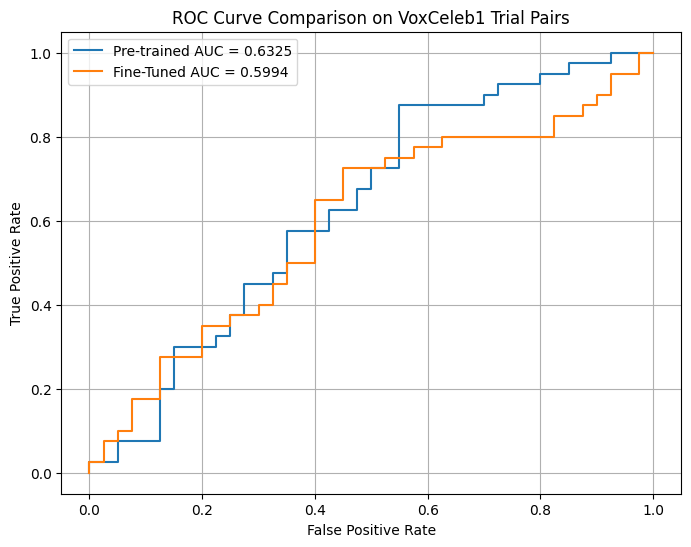

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(pre_fpr, pre_tpr, label=f"Pre-trained AUC = {auc(pre_fpr, pre_tpr):.4f}")
plt.plot(ft_fpr, ft_tpr, label=f"Fine-Tuned AUC = {auc(ft_fpr, ft_tpr):.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison on VoxCeleb1 Trial Pairs")
plt.legend()
plt.grid(True)
plt.show()